# Qiskit Fall Fest 2023

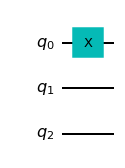

In [8]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.x(0)

qc.draw("mpl")

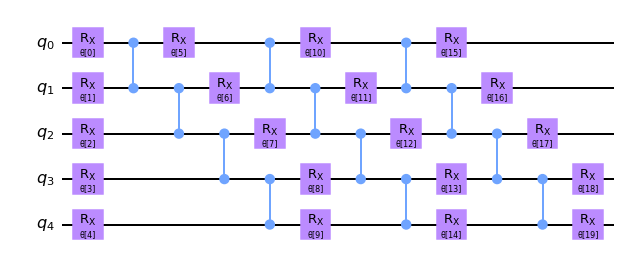

In [9]:
from qiskit.circuit.library import TwoLocal
from math import pi

reference_circuit = TwoLocal(5, "rx", "cz", entanglement="linear", reps=3)

reference_circuit.decompose().draw("mpl")

In [10]:
from qiskit.circuit import QuantumCircuit, Parameter

def twolocal(n, gates=["ry"], entanglement="linear", reps=1, par_name="x"):
    
    
    def lin_entanglement(qc):
        n = qc.num_qubits
        for qubit in range(0, n-1):
            qc.cx(qubit, qubit+1)
            
    def single_rep(qc, gates, par):
        n = qc.num_qubits
        for i in range(0, n):
            for gate in gates:
                if gate == "ry":
                    qc.ry(par[i], i)

                    
    par = [Parameter("{}_{}".format(par_name,i)) for i in range(0,n*len(gates)*(reps+1))]
    qc = QuantumCircuit(n)

    
    single_rep(qc, gates, par[:(n*len(gates))])
    qc.barrier()
    
    for rep in range(1, reps+1):
        if entanglement == "linear":
            lin_entanglement(qc)
        qc.barrier()
        single_rep(qc, gates, par[n*len(gates)*(rep):n*len(gates)*(rep+1)])
        qc.barrier()

    return qc

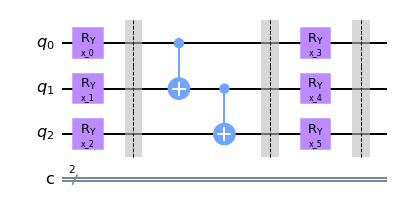

In [11]:
qc = QuantumCircuit(3, 2)
ansatz = twolocal(3)
circuit = qc.compose(ansatz)

circuit.draw("mpl")

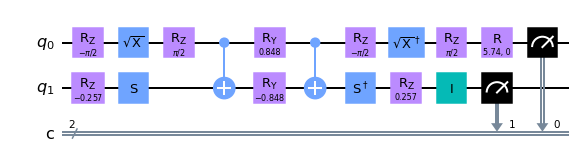

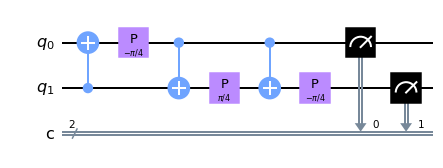

>>> Quasi-probability distribution: [{0: 0.4059100518225088, 1: 0.0320881623296046, 2: 0.0411727809637867, 3: 0.5208290048841004}, {0: 1.0}]


In [12]:
from qiskit.primitives import Sampler, Estimator

sampler = Sampler()
estimator = Estimator()



from qiskit.circuit.random import random_circuit

circuits = (
    random_circuit(2, 2, seed=0, measure=True).decompose(reps=1),
    random_circuit(2, 2, seed=1, measure=True).decompose(reps=1),
)

job = sampler.run(circuits)
result = job.result()

[display(cir.draw("mpl")) for cir in circuits]
print(f">>> Quasi-probability distribution: {result.quasi_dists}")

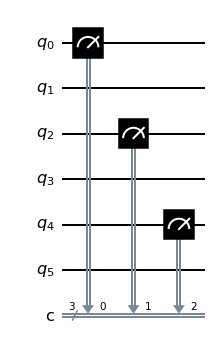

In [20]:
from qiskit.providers.aer import AerSimulator

nq = 6
nc = 3
qc = QuantumCircuit(nq, nc)

for i in range(0, nc):
    qc.measure(2*i, i)
    
qc.draw("mpl")

In [21]:
sim = AerSimulator(shots=shots)

job = sim.run(qc)
result = job.result()

result.get_counts()

{'000': 512}

In [25]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

#service = QiskitRuntimeService(channel="ibm_quantum")

backend = Sampler("ibmq_qasm_simulator")

job = backend.run(qc)
result = job.result()
result

IBMRuntimeError: 'Failed to run program: "HTTPSConnectionPool(host=\'api.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /runtime/jobs (Caused by ResponseError(\'too many 500 error responses\'))"'

In [35]:
# Bell State prep

# Phi_+
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
print("Phi_+ --->", simulate(qc))

# Phi_-
qc = QuantumCircuit(2)
qc.x(0)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
print("Phi_- --->", simulate(qc))

# Psi_+
qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
print("Psi_+ --->", simulate(qc))

# Psi_-
qc = QuantumCircuit(2)
qc.x(0)
qc.x(1)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
print("Psi_- --->", simulate(qc))

Phi_+ ---> {'00': 513, '11': 511}
Phi_- ---> {'00': 531, '11': 493}
Psi_+ ---> {'10': 537, '01': 487}
Psi_- ---> {'10': 538, '01': 486}


In [27]:
def simulate(qc, shots=1024):

    sim = AerSimulator(shots=shots)

    job = sim.run(qc)
    result = job.result()

    return result.get_counts()

In [108]:
def binary_sum(input_circ):
    output_circ = input_circ
    output_circ.barrier()
    output_circ.ccx(1,2,0)
    output_circ.cx(2,1)
    output_circ.x(2)
    output_circ.measure_all()
    
    return output_circ

{'000': 1024}


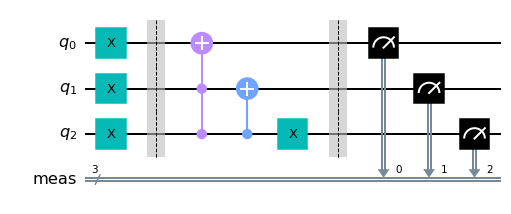

In [113]:
input_circ = QuantumCircuit(3)
input_circ.x(2)
input_circ.x(1)
input_circ.x(0)

qc = binary_sum(input_circ)
print(simulate(qc))

qc.draw("mpl")